# 과제 2. CNN : CIFAR-10 (다중분류)

> 2071066 김하은  
 계산과학 프로그래밍 및 실습


---

CNN을 이용한 CIFAR-10 분류

- HW2.ipynb 파일을 다운로드하여 사용 (주석 참고)
- 제출기한: 11/20 월 23:59 (기한 잘 확인하여 기한내 제출. 늦은 제출 인정하지 않습니다.)
- 제출방법: 사이버 캠퍼스 "과제2"에 파일 업로드 제출 (이메일 제출 받지 않습니다.)
아래와 같이 파일명과 형식으로 제출
- 코드: HW2_학번.ipynb (주석에서 언급된 부분이 출력되어 확인 가능하도록 저장한 파일)
- 신경망 모델: HW2_학번.pt (제출한 정확도를 얻은 신경망 모델(with shape) 저장 파일)
- 코드 5점 + 테스트 데이터 분류 정확도 5점 (80% 이상 : 1점, 82% 이상 : 3점, 84% 이상 : 5점)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset

In [5]:
# device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Current device is', device)

# for reproducibility
torch.manual_seed(2023)
if device == 'cuda':
    torch.cuda.manual_seed_all(2023)

Current device is cuda


## 1. Data

CIFAR-10

In [6]:
# Cifar10 dataset
cifar10 = datasets.CIFAR10(root='./data', train=True, download=True,
                           transform=transforms.ToTensor())

cifar_test = datasets.CIFAR10(root='./data', train=False, download=True,
                              transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


Data augmentation

In [7]:
# Fix image size
# Data augmentation and normalization for training
# Just normalization for validation
# overfitting을 막기 위해 데이터 증식

basic_transforms = [transforms.ToTensor()]

#이렇게 데이터를 조금씩 변형해보자!
data_aug = [transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
            transforms.RandomRotation(degrees=(-10, 10)),
            transforms.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.2))]

data_aug += basic_transforms


cifar10_original = datasets.CIFAR10(root='./data', train=True, download=True,transform=transforms.Compose(basic_transforms))
cifar10_aug = datasets.CIFAR10(root='./data', train=True, download=True,transform=transforms.Compose(data_aug))
cifar_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
aug_image_datasets = {'train': torch.utils.data.ConcatDataset([cifar10_original, cifar10_aug])}  #ConcatDataset를 통해 데이터 셋을 붙임

cifar10=aug_image_datasets['train']

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


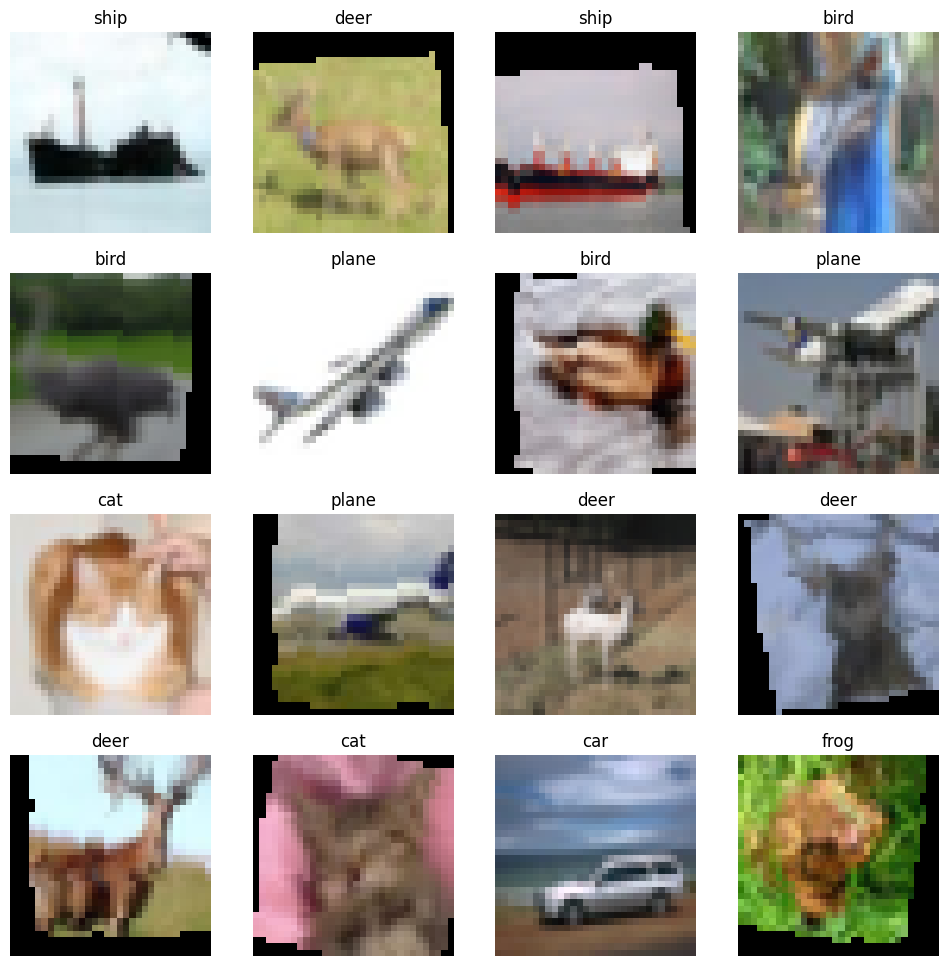

In [8]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# 이미지를 보여주기 위한 함수
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))



figure = plt.figure(figsize=(12, 12))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(cifar10), size=(1,)).item()
    img, label = cifar10[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    imshow(img)
plt.show()

In [9]:
# train, validation set split
train_length = len(cifar10)
print(train_length)
train_data, val_data = torch.utils.data.random_split(cifar10,[83334, 16666]) #5:1로 train, val data의 비율 나눔

100000


In [10]:
# print number of training/validation/test data
# 길이 계산
train_length = len(train_data)
val_length=len(val_data)
test_length = len(cifar_test)
print(train_length,val_length,test_length)

83334 16666 10000


truck


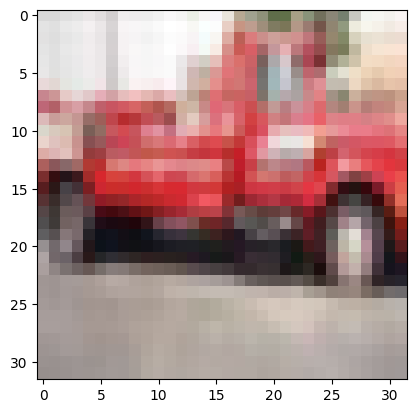

In [11]:
# train_data 첫번째 이미지 및 클래스 출력

image, label = train_data[0] # train_data에서 첫 번째 데이터 가져오기
imshow(image) #이미지 출력
print(classes[label]) # 클래스 출력

In [12]:
# image size 확인
print(image.shape) #이미지 size : c=3, h=32, w=32

torch.Size([3, 32, 32])


In [13]:
# set hyperparameters
learning_rate = 0.001
epochs = 20
batch_size = 100

In [14]:
# train, validation, test dataset loader (for mini-batch training)
# For test dataset loader, set 'batch_size=len(test_data), shuffle=False'.

train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True) #train에서는 섞어서 가져오는게 좋음
val_loader = torch.utils.data.DataLoader(dataset=val_data,
                                         batch_size=batch_size,
                                         shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=cifar_test,
                                          batch_size=len(cifar_test),  # 잘못 예측한 데이터 찾기 위해
                                          shuffle=False)

## 2. Model

In [15]:
# CNN Model class
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.drop_prob = 0.5
        # 필터 (50,3,5,5)
        # L1 ImgIn shape=(?, 3, 32, 32)
        #    Conv     -> (?, 50, 30, 30) 30=(32+2-4)/1
        #    Pool     -> (?, 50, 15, 15)
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=4, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        # L2 ImgIn shape=(?, 50, 15, 15)
        #    Conv      ->(?, 64, 14, 14)
        #    Pool      ->(?, 64, 7, 7)
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(50, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(p=self.drop_prob))

        # L3 ImgIn shape=(?, 64, 7, 7)
        #    Conv      ->(?, 128, 7, 7)
        #    Pool      ->(?, 128, 4, 4)
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=1))

        # L4 ImgIn shape=(?, 128, 4, 4)
        #    Conv      ->(?, 200, 7, 7)
        #    Pool      ->(?, 200, 4, 4)
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 200, 3, stride=1, padding=1),
            nn.BatchNorm2d(200),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=1))


        # L5 FC (?, 200*4*4) inputs -> (?, 512) outputs
        self.fc1 = nn.Linear(200*3*3, 512)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.layer5 = torch.nn.Sequential(
            self.fc1,
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=self.drop_prob))

        # L6 Final FC (?, 512) inputs -> (?, 10) outputs
        self.fc2 = nn.Linear(512, 10)
        nn.init.kaiming_normal_(self.fc2.weight)


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.layer5(out)
        out = self.fc2(out)
        return out

In [16]:
# instantiate CNN model
model = CNN().to(device)

# define loss & optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
# print model
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 50, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(50, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, paddin

## 3. Training

In [18]:
# train model
# epoch마다 training/validation loss와 accuracy 출력 및 loss와 accuracy 그래프 그리기 위한 list 만들기

train_batch = len(train_loader)
val_batch = len(val_loader)
print(train_batch, val_batch, sep='\n')

# train model
print('Learning started.')

train_loss_list = []
train_acc_list = []

val_loss_list = []
val_acc_list = []

best_val_loss = 10**9   # 큰 값으로 초기값 가정
patience_limit = 3    # 몇 번의 epoch까지 지켜볼지를 결정
patience_check = 0    # 현재 몇 epoch 연속으로 loss 개선 안되었는지 기록

for epoch in range(epochs):
    # training
    train_loss = 0
    correct = 0

    for X, Y in train_loader:
        # image is already size of (3, 32, 32), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        Y_pred = model.forward(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()

        train_loss += loss / train_batch

        correct_prediction = torch.argmax(Y_pred, 1) == Y
        correct += correct_prediction.sum()

    train_acc = (100*correct/len(train_loader.dataset))
    train_acc_list.append(train_acc.item())
    train_loss_list.append(train_loss.item())


    # validation
    with torch.no_grad():
        val_loss = 0
        correct = 0

        for X, Y in val_loader:
            X_val = X.to(device)
            Y_val = Y.to(device)

            Y_pred = model.forward(X_val)
            loss = criterion(Y_pred, Y_val)

            val_loss += loss / val_batch

            correct_prediction = torch.argmax(Y_pred, 1) == Y_val
            correct += correct_prediction.sum()

        val_acc = (100*correct/len(val_loader.dataset))
        val_acc_list.append(val_acc.item())
        val_loss_list.append(val_loss.item())

    print("[Epoch %2d] loss %.4f  acc %.2f, val loss %.4f  val acc %.2f"
          % (epoch+1, train_loss, train_acc, val_loss, val_acc))

    # early stopping
    if val_loss > best_val_loss: # loss가 개선되지 않은 경우
        patience_check += 1
        if patience_check >= patience_limit: # early stopping 조건 만족 시 조기 종료
            print('Early Stopping!')
            break
    else: # loss가 개선된 경우
        best_val_loss = val_loss
        patience_check = 0

print('Learning Finished!')


834
167
Learning started.
[Epoch  1] loss 1.6647  acc 40.39, val loss 1.3651  val acc 50.67
[Epoch  2] loss 1.2492  acc 55.12, val loss 1.1606  val acc 58.38
[Epoch  3] loss 1.0994  acc 60.94, val loss 1.0661  val acc 62.80
[Epoch  4] loss 1.0189  acc 63.94, val loss 0.9923  val acc 64.97
[Epoch  5] loss 0.9549  acc 66.06, val loss 0.9829  val acc 65.46
[Epoch  6] loss 0.9054  acc 68.20, val loss 0.9443  val acc 67.05
[Epoch  7] loss 0.8702  acc 69.35, val loss 0.8943  val acc 68.62
[Epoch  8] loss 0.8305  acc 70.87, val loss 0.8695  val acc 69.78
[Epoch  9] loss 0.8040  acc 71.71, val loss 0.8455  val acc 70.85
[Epoch 10] loss 0.7866  acc 72.44, val loss 0.8318  val acc 71.02
[Epoch 11] loss 0.7615  acc 73.29, val loss 0.8285  val acc 71.25
[Epoch 12] loss 0.7414  acc 73.94, val loss 0.8097  val acc 71.90
[Epoch 13] loss 0.7270  acc 74.33, val loss 0.8010  val acc 72.13
[Epoch 14] loss 0.7091  acc 75.11, val loss 0.7780  val acc 73.01
[Epoch 15] loss 0.6949  acc 75.71, val loss 0.7693

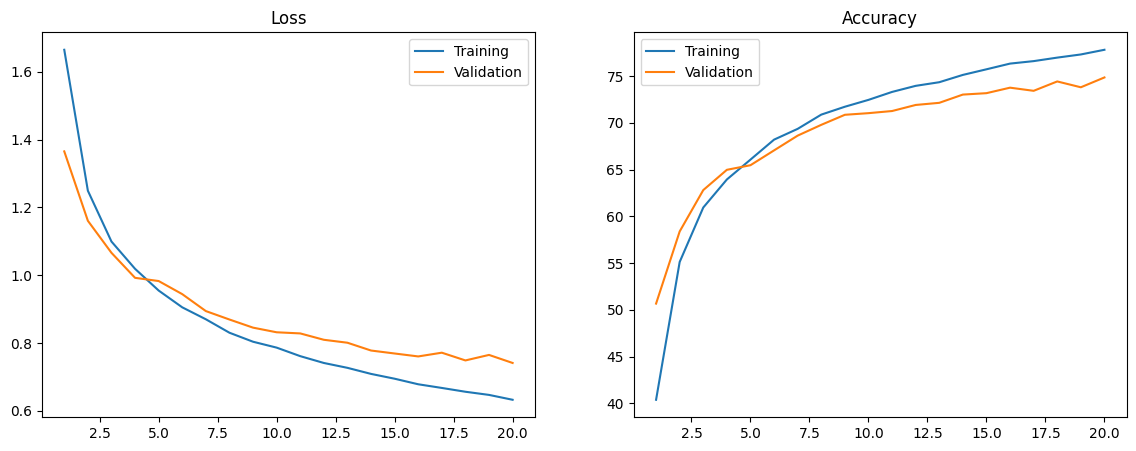

In [19]:
# plot loss and accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), train_loss_list, range(1, epochs+1), val_loss_list)
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), train_acc_list, range(1, epochs+1), val_acc_list)
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')
plt.show()

## 4. Test Model

In [31]:
# Test model and print test accuracy
with torch.no_grad():
    model.eval()
    correct = 0
    # Test the model using test sets
    for X, Y in test_loader:
        X_test = X.to(device)
        Y_test = Y.to(device)

        Y_pred = model.forward(X_test)
        prediction = torch.argmax(Y_pred, 1)
        correct_prediction = prediction == Y_test
        correct += correct_prediction.sum()

    accuracy = 100*correct/len(test_loader.dataset)
    print('Test set Accuracy: %.2f' % (accuracy))

Test set Accuracy: 82.44


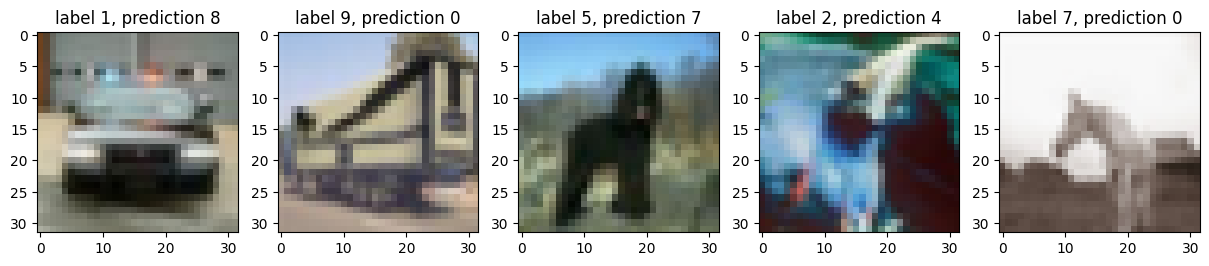

In [33]:
# 잘못 예측한 5개 이미지 보기 (진짜 라벨과 예측 라벨 같이 출력)
false_list = []
for i, c in enumerate(correct_prediction):
    if c == False:
        false_list.append(i)

r = 10
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(cifar_test.data[false_list[r+i]])
    plt.title('label %d, prediction %d'
              %(cifar_test.targets[false_list[r+i]], prediction[false_list[r+i]]))
plt.show()

## 5. Save Model

In [36]:
# save model (저장한 .pt 파일 제출)


from google.colab import drive
drive.mount('/content/drive')

torch.save(model.state_dict(), '/content/drive/MyDrive/HW2_2071066.pt')

# shape 정하기
my_model = CNN().to(device)
# weight 불러오기
my_model.load_state_dict(torch.load('/content/drive/MyDrive/HW2_2071066.pt'))
my_model.eval() # be sure to call model.eval()
                # to set the dropout and batch normalization layers to evaluation mode.

# Test model and check accuracy
with torch.no_grad():
    model.eval()
    correct = 0
    # Test the model using test sets
    for X, Y in test_loader:
        X_test = X.to(device)
        Y_test = Y.to(device)

        Y_pred = model.forward(X_test)
        prediction = torch.argmax(Y_pred, 1)
        correct_prediction = prediction == Y_test
        correct += correct_prediction.sum()

    accuracy = 100*correct/len(test_loader.dataset)
    print('Test set Accuracy: %.2f' % (accuracy))




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Test set Accuracy: 82.44
